## Performance shift between present-day & future climate

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from datetime import datetime
from sklearn.preprocessing import StandardScaler

from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.diverging import PuOr_7

from ideotype.data_process import (read_data,
                                   fetch_norm_mean_disp,
                                   fetch_mean_disp_diff,
                                   fetch_mean_stability_diff,
                                   fetch_emps,
                                   agg_sims)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               identify_rankchanged_phenos,
                               phenostage_climate)
from ideotype.figures import (plot_rankchange,
                              plot_params_heatmap,
                              plot_cspace_rank,
                              plot_cspace_yield,
                              plot_yield_stability_scatter_shift)
from ideotype.init_params import params_sample
from ideotype.utils import fold
from ideotype.data_process import parse_mature
from ideotype import DATA_PATH

In [2]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

## Visualize change in phenotype ranking 

future top ranks less than present day
future top ranks less than present day


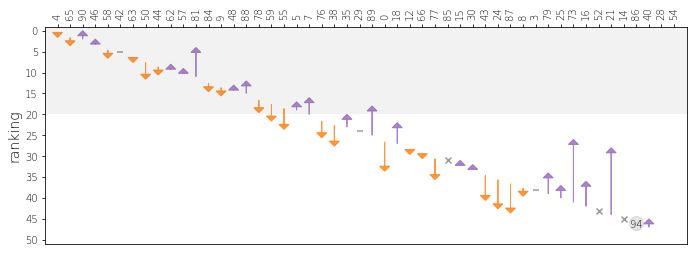

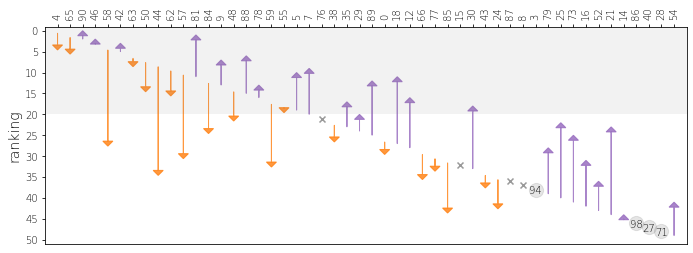

In [3]:
plot_rankchange(20, 1, 1, 'f2050')
plot_rankchange(20, 1, 1, 'f2100')

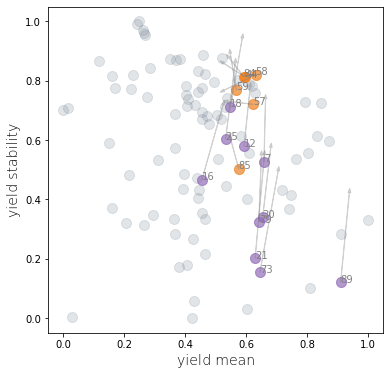

In [3]:
plot_yield_stability_scatter_shift('present', 'f2100', 20, 1, 1, 10, save=True)

In [8]:
# identify pheno rankchanges
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'
rank_limit = 10

(phenos_improved, phenos_declined,
 phenos_improved_rc, phenos_declined_rc) = identify_rankchanged_phenos(
    n_pheno, w_yield, w_disp, future_run, rank_limit)

In [10]:
# identify improved & declined phenos
(phenos_improved, phenos_declined,
 rankchange_up, rankchange_down) = identify_rankchanged_phenos(20,1,1,'f2100',8)
print(phenos_improved)
print(phenos_declined)

# identify emps
emps_list = ['jday', 'pheno_days', 'LA', 'An', 'gs']
emps_description = ['grain-fill start', 'grain-fill duration', 'leaf area',
                    'photosynthesis', 'stomatal conductance']

# fetch emps
df_emps_present, df_emps_present_std = fetch_emps('present')
df_emps_f2100, df_emps_f2100_std = fetch_emps('f2100')

# calcualte emp means
emps_improved = df_emps_present_std[
    df_emps_present_std.cvar.isin(phenos_improved)].mean()[emps_list]
emps_declined = df_emps_present_std[
    df_emps_present_std.cvar.isin(phenos_declined)].mean()[emps_list]

# calcualte emp standard errors
sds_improved = []
sds_declined = []

sds = [sds_improved, sds_declined]
pheno_groups = [phenos_improved, phenos_declined]
for item in [0,1]:
    sd_list = sds[item]
    pheno_group = pheno_groups[item]
    for emp in emps_list:
        emp_values = df_emps_present_std[
            df_emps_present_std.cvar.isin(pheno_group)][emp]
        emp_se = np.std(emp_values)
        sd_list.append(emp_se)

[21, 25, 18, 73, 30, 89, 12, 7, 79, 16, 81, 88, 5]
[44, 58, 57, 59, 84, 85]


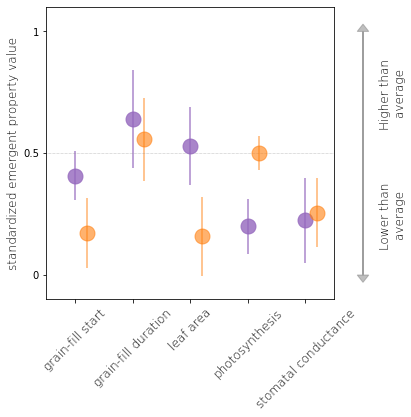

In [11]:
# visualization
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

ax.errorbar(np.arange(len(emps_list)), emps_improved, yerr=sds_improved, 
            c='tab:purple', fmt='o', ms=15, alpha=0.8)
ax.errorbar(np.arange(len(emps_list))+0.2, emps_declined, yerr=sds_declined,
            c='tab:orange', fmt='o', ms=15, alpha=0.6)

ax.arrow(len(emps_list), 0, 0, 1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)
ax.arrow(len(emps_list), 1, 0, -1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)

ax.annotate('Lower than \naverage', (len(emps_list)+0.5, 0.25), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('Higher than \naverage', (len(emps_list)+0.5, 0.75), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

ax.set_xlim(-0.5, len(emps_list)-0.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks(np.arange(len(emps_list)))
ax.set_xticklabels(emps_description, rotation=45, fontweight='light', fontsize=12)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_ylabel('standardized emergent property value', fontweight='light', fontsize=12)
ax.axhline(y=0.5, color='grey', linewidth=0.5, linestyle=':')

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3)

## Identify phenotypes that improved most in ranking

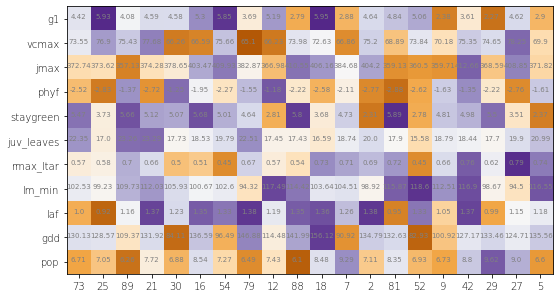

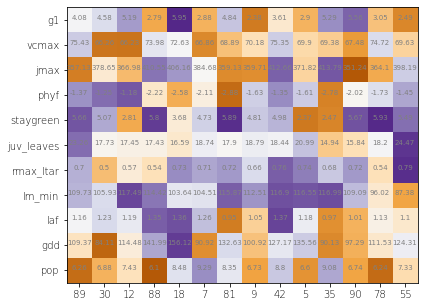

In [18]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
plot_params_heatmap(df_params, phenos_improved, save=True, save_text='f2100_improved_y1_d1')
plot_params_heatmap(df_params, phenos_targeted, fig_w=6.5, save=True, save_text='f2100_targeted_y1_d1')

### Plot out change in yield vs. stability

In [4]:
# Identify phenos
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

Text(0.5, 1.0, 'Yield mean and disparsion - averaged over all sites')

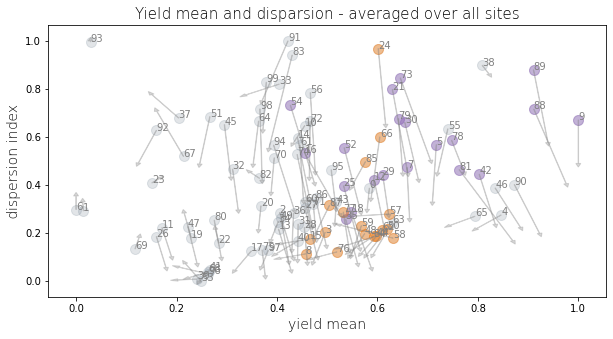

In [7]:
run_name_present = 'present'
run_name_future = 'f2100'
phenos_improved = phenos_improved[:20]
#phenos_declined = [58,50,62,44,57,84,59,66,77]
phenos_declined = [58,50,62,44,57,84,48,59,66,77,85,87,24,76,15,8,3]
#phenos = phenos_improved + phenos_declined
phenos = np.arange(100)

yield_mean_norm_present, yield_disp_norm_present = fetch_norm_mean_disp(
    run_name_present)
yield_mean_norm_future, yield_disp_norm_future = fetch_norm_mean_disp(
    run_name_future)
diffs_yield, diffs_disp = fetch_mean_disp_diff(
    run_name_present, run_name_future, phenos)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.scatter(yield_mean_norm_present, yield_disp_norm_present,
           c='slategrey', s=100, alpha=0.2)
ax.scatter(yield_mean_norm_present[phenos_improved],
           yield_disp_norm_present[phenos_improved],
           c='tab:purple', s=100, alpha=0.4)
ax.scatter(yield_mean_norm_present[phenos_declined],
           yield_disp_norm_present[phenos_declined],
           c='tab:orange', s=100, alpha=0.4)

for item, pheno in enumerate(phenos):
    plt.arrow(yield_mean_norm_present[pheno],
              yield_disp_norm_present[pheno],
              diffs_yield[item], diffs_disp[item],
              color='grey', alpha=0.3,
              head_width=0.01)

for pheno in phenos:
    ax.annotate(pheno, (yield_mean_norm_present[pheno],
                        yield_disp_norm_present[pheno]), c='grey')

#ax.set_ylim(-0.1, 1.1)
#ax.set_xlim(-0.1, 1.1)
ax.set_xlabel('yield mean', fontweight='light', size=14)
ax.set_ylabel('dispersion index', fontweight='light', size=14)
ax.set_title('Yield mean and disparsion - averaged over all sites',
             fontweight='light', size=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_rankchange.png', format='png', dpi=800)

## Shift in top performers param makeup

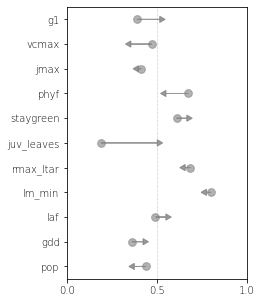

In [182]:
# identify top phenos
top_phenos = rank_top_phenos('present', 20, 1, 1)
top_phenos = top_phenos[:10]
#top_phenos = top_phenos[:20]

# identify phenos
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

# fetch params
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

for param in params:
    df_params_fold[param] = fold(df_params[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# visualization
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

# comparing top performers today vs. targeted phenotypes that improved
for item, param in enumerate(params[::-1]):
    p1 = df_params_fold.iloc[top_phenos][param].mean()    
    p2 = df_params_fold.iloc[phenos_targeted][param].mean()
    ax.scatter(df_params_fold.iloc[top_phenos][param].mean(), item,
               color='grey', s=60, alpha=0.6)
    ax.arrow(p1, item, (p2-p1), 0, color='grey', alpha=0.8,
             head_length=0.03, head_width=0.25)
    
ax.set_xlim(0,1)
ax.set_ylim(-0.5,10.5)
plt.xticks(fontweight='light')
ax.set_xticks([0,0.5,1])
ax.set_yticks(np.arange(11))
ax.set_yticklabels(params[::-1], fontweight='light')

ax.axvline(x=0.5, color='grey', linewidth=0.5, linestyle=':')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_change.png', format='png', dpi=800)

## Shift in performance distribution

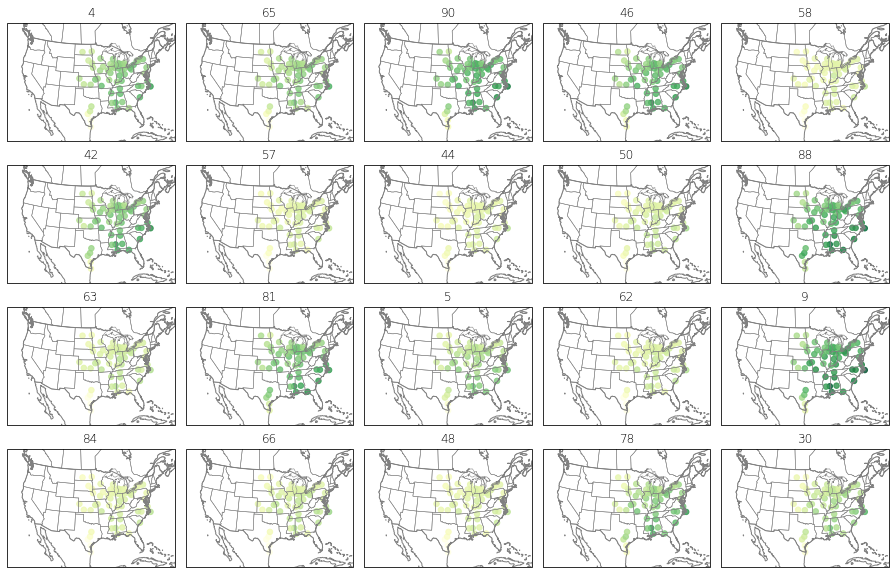

In [22]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,count+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=80, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(cvar, fontweight='light')

fig.subplots_adjust(wspace=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_yield_top_phenos_sortby_top_prevalence.png', format='png', dpi=800)

### Performance change in climate space

In [3]:
# Current climate
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    os.path.join(DATA_PATH, 'files', f'filepaths_{run_name}.yml'))
df_grouped_present = df_all.groupby(['cvar', 'site']).mean().reset_index()
df_gseason_climate = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))
df_waterdeficit = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_temp_gf_present, df_vpd_gf_present, df_wd_gf_present = phenostage_climate(
    df_all, df_gseason_climate, df_waterdeficit, 3)

# f2100 climate
run_name = 'f2100'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    os.path.join(DATA_PATH, 'files', f'filepaths_{run_name}.yml'))
df_grouped_f2100 = df_all.groupby(['cvar', 'site']).mean().reset_index()
df_gseason_climate = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))
df_temp_gf_f2100, df_vpd_gf_f2100, df_wd_gf_f2100 = phenostage_climate(
    df_all, df_gseason_climate, df_waterdeficit, 3)

# additional phenostages
#df_temp_em, df_vpd_em, df_wd_em = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 0)
#df_temp_ti, df_vpd_ti, df_wd_ti = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 1)
#df_temp_ts, df_vpd_ts, df_wd_ts = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 2)
#df_temp_em_f2100, df_vpd_em_f2100, df_wd_em_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 0)
#df_temp_ti_f2100, df_vpd_ti_f2100, df_wd_ti_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 1)
#df_temp_ts_f2100, df_vpd_ts_f2100, df_wd_ts_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 2)
    
# Overall gseason climate
#site_temps = df_all.groupby('site').mean().temp
#site_vpds = df_all.groupby('site').mean().vpd
#site_precips = df_all.groupby('site').mean().precip

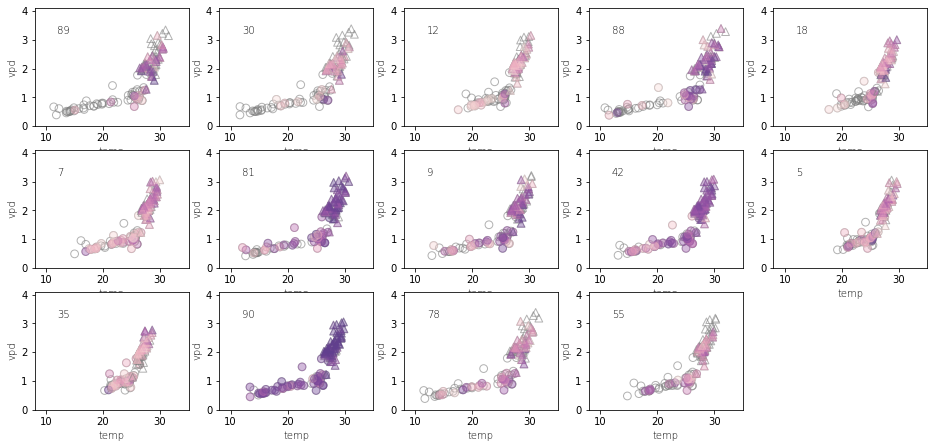

In [4]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_future = identify_top_phenos('f2100', 20, 1, 1)

plot_cspace_rank(phenos_targeted, mx_present, mx_future,
                 df_temp_gf_present, df_vpd_gf_present,
                 df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

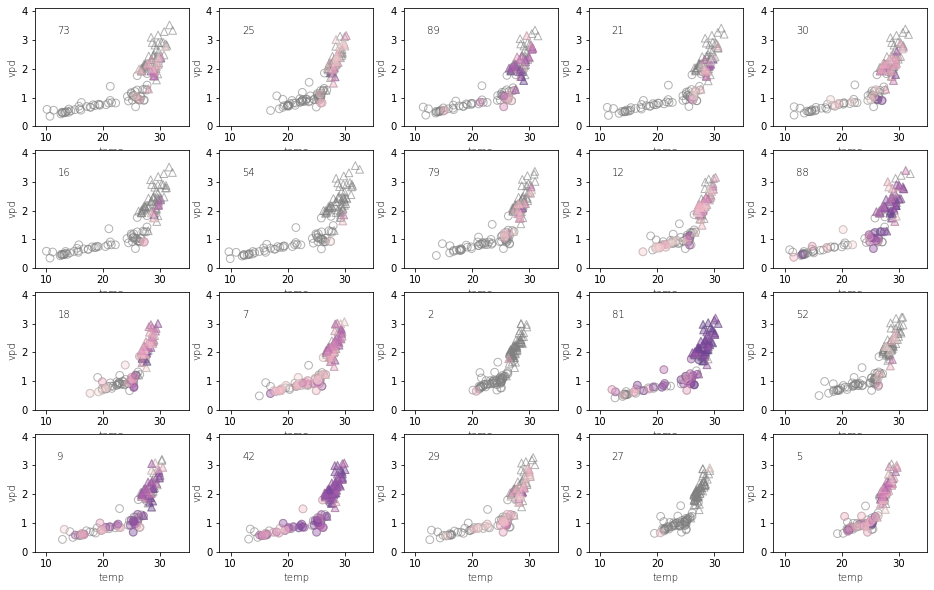

In [5]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_future = identify_top_phenos('f2100', 20, 1, 1)

plot_cspace_rank(phenos_improved[:20], mx_present, mx_future,
                 df_temp_gf_present, df_vpd_gf_present,
                 df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

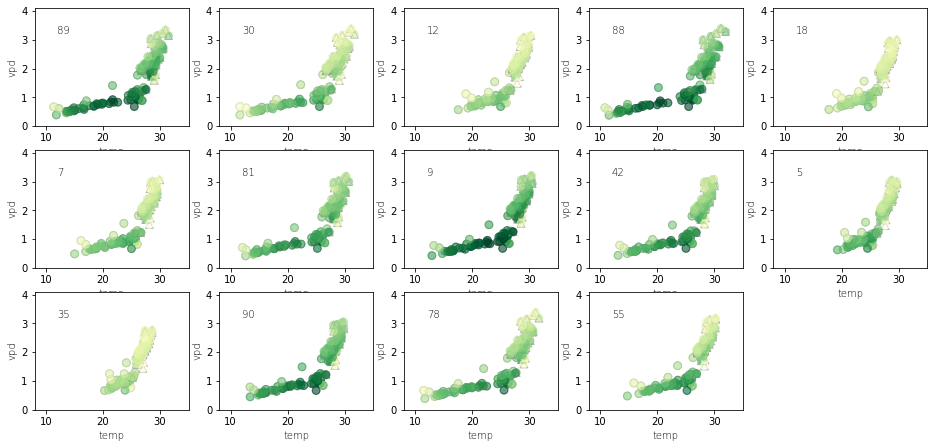

In [4]:
# Identify targeted phenos & ranks
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

plot_cspace_yield(phenos_targeted, df_grouped_present, df_grouped_f2100,
                  df_temp_gf_present, df_vpd_gf_present,
                  df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

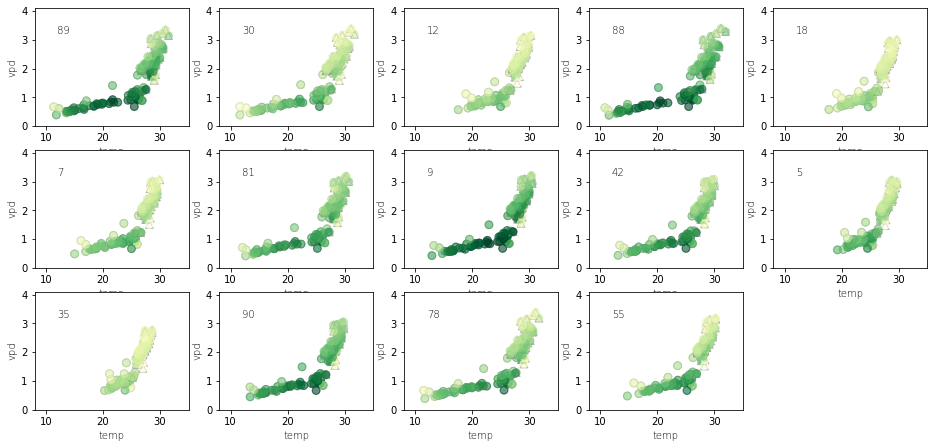

In [3]:
# Identify targeted phenos & ranks
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

plot_cspace_yield(phenos_targeted, df_grouped_present, df_grouped_f2100,
                  df_temp_gf_present, df_vpd_gf_present,
                  df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')